# Discerning the language used between r/godtiersuperpowers vs r/LifeProTips

Can we make a model that is able to discern wether a post holds genuine tips to help people out or... if it's a completely fictional fantasy?

_____

### Imports

In [2]:
import func as func
import praw
from psaw import PushshiftAPI
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.naive_bayes import MultinomialNB

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extracting information from 2000 subreddit posts using PRAW


## Accessing Python Reddit API Wrapper (PRAW)

In [3]:
#reddit instance to gain access to reddit content
reddit = praw.Reddit(client_id = 'WOnuVMarbgdLMOZ8qVZu_g',
                    client_secret = '-b0KDq16LqaTYB0y77h0N9E314o-8A',
                    username = 'r2foru',
                    password = '',
                    user_agent = 'yee')


Version 7.5.0 of praw is outdated. Version 7.6.0 was released 7 days ago.


### 1. Function that takes targeted information and saves to a csv file

#### **How it's done:** 
- Iterate through list of subreddits to:
    1. Create csv pathway
    2. Access subreddit
    3. Describe what type of posts to sort by- top/ hot/ new
        - Also outline how many posts to take
    4. Create dictionary to store post information
     
     <br>
- Iterate each post of each subreddit to:
    5. Access post characteristics from post object and append to dictionary
    6. Create dataframe from said dictionary and save it as a csv file

#### Objectives: 
- Sort by 'top' and 'hot'
- Collect 2000 posts per subreddit
- Extract from each post their:
    - ID
    - URL
    - Title
    - Self text
    - Score
    - Number of comments

**NOTE:** Refer to README to understand these characteristics of a post

*The fucntion can be found in func.py*

### 2. Saving csv files of 'LifeProTips' and 'godtiersuperpowers' sorted by top, hot and new 
Using func.extract_subreddit (function is found in .py file) to make 4 seperate csv files containing all the information outlined previously

In [4]:
#list of chosen subreddits
# sub_list = ['LifeProTips', 'godtiersuperpowers']

#performing function onto these subreddits
# func.extract_subreddit(sub_list) 

### 3. Reading the CSV files

In [5]:
gt_top = pd.read_csv('../data/godtiersuperpowers_top_scraped.csv')
gt_hot = pd.read_csv('../data/godtiersuperpowers_hot_scraped.csv')
gt_new = pd.read_csv('../data/godtiersuperpowers_new_scraped.csv')

lpt_top = pd.read_csv('../data/LifeProTips_top_scraped.csv')
lpt_hot = pd.read_csv('../data/LifeProTips_hot_scraped.csv')
lpt_new = pd.read_csv('../data/LifeProTips_new_scraped.csv')

In [6]:
gt_hot.head(2)

,id,url,title,self_text,score,num_comments,subreddit
0,unbnr1,https://www.reddit.com/r/godtiersuperpowers/co...,You gain all the abilities and items from ever...,NaN,1087,106,godtiersuperpowers
1,uno321,https://www.reddit.com/r/godtiersuperpowers/co...,whenever you stare at someone for more than 5 ...,NaN,43,7,godtiersuperpowers


### 4. Combining the data sets
- PRAW is unable to extract exactly the 1000 posts for each category of posts. lpt_hot only had 338 entries compared to gt with 999. I consciously ignored giving godtiersuperpowers posts sorted by 'new' to achieve a better class balance between subreddits. Improving the class balance from 6:4 to 5:5 increased accuracy by 10%, recall by 35% and specificity by 2%.
- The dataset had been shuffled so that the observations were assorted randomly.

In [7]:
#these aren't consistently 1000 entries each
gt_top.shape, gt_hot.shape, gt_new.shape

((1000, 7), (999, 7), (991, 7))

In [8]:
#lpt_hot has 338 observations 
lpt_top.shape, lpt_hot.shape, lpt_new.shape

((988, 7), (338, 7), (982, 7))

In [9]:
gt = pd.concat([gt_top, gt_hot], axis = 0)
lpt = pd.concat([lpt_top, lpt_hot, lpt_new], axis = 0)

#ignore_index is needed as index will duplicate when concatenating
df = pd.concat([lpt, gt], axis = 0, ignore_index = True)

#To increase randomness in our dataset, we reshuffle the dataframe by rows since concatenation added all gt observations below all
#lpt observations
df = df.sample(frac = 1, ignore_index = True)

In [10]:
df.head()

,id,url,title,self_text,score,num_comments,subreddit
0,ddxwd0,https://www.reddit.com/r/godtiersuperpowers/co...,"Every bit of water or food you ""waste"" goes di...",NaN,8784,89,godtiersuperpowers
1,te88dp,https://www.reddit.com/r/godtiersuperpowers/co...,Being able to summon s bagel in my hand at any...,NaN,8,2,godtiersuperpowers
2,ll84gb,https://www.reddit.com/r/LifeProTips/comments/...,"LPT: if you need to defrost your windshield, y...",Flipping down the sun visors will direct the a...,37723,1099,LifeProTips
3,g70mjs,https://www.reddit.com/r/LifeProTips/comments/...,LPT: You Must Do an Absolute 100% Dry Run Test...,Got a big presentation? Got a big event you a...,35917,730,LifeProTips
4,8b3xt9,https://www.reddit.com/r/LifeProTips/comments/...,"LPT: When you spill wine on fabric (clothing, ...",NaN,51206,1050,LifeProTips


### 5. Data Cleaning? 
Nearly half of the posts don't have a self-text, represented as a np.nan. Fortunately, there are no issues with our dtypes.

With such a high number of null values and enough language information from the words in the 'titles', I've decided to make a placeholder that represents 1 if there was a value in there and 0 if there wasn't anything. This will be for later use in our model.

In [11]:
#self_text nearly has half entries as null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4307 entries, 0 to 4306
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            4307 non-null   object
 1   url           4307 non-null   object
 2   title         4307 non-null   object
 3   self_text     2280 non-null   object
 4   score         4307 non-null   int64 
 5   num_comments  4307 non-null   int64 
 6   subreddit     4307 non-null   object
dtypes: int64(2), object(5)
memory usage: 235.7+ KB


**Absence of self_text in both subreddits**<br>
It seems that LifeProTips takes advantage of self-text to explain things in further detail. This imbalance outlines a characteristic of LifeProTips vs godtiersuperpowers.

In [12]:
#This finds the amount of instances that each subreddit that have np.nan in 'self_text'
df[df['self_text'].isnull()]['subreddit'].value_counts()

godtiersuperpowers    1211
LifeProTips            816
Name: subreddit, dtype: int64

**Addressing np.nan in self_text**<br> Binarize self_text so that it represents the absence or existance of self_text.

In [13]:
#this will transform self_text to the int values of a boolean that represents as 1 when there was a value, and 0 when it was a np.nan
df['self_text'] = df['self_text'].notnull().astype(int)

In [14]:
df.head(1)

,id,url,title,self_text,score,num_comments,subreddit
0,ddxwd0,https://www.reddit.com/r/godtiersuperpowers/co...,"Every bit of water or food you ""waste"" goes di...",0,8784,89,godtiersuperpowers


**Saving cleaned and concatenated data to new csv file**

In [15]:
# df.to_csv('../data/sub_data.csv', index = False)

# EDA

In [16]:
#reading the cleaned and concatenated data
df = pd.read_csv('../data/sub_data.csv')

In [17]:
df.shape

(3961, 9)

In [18]:
df['subreddit'].value_counts(normalize = True)

godtiersuperpowers    0.504671
LifeProTips           0.495329
Name: subreddit, dtype: float64

### Duplicates?
Duplicates could be a problem in creating bias if there were persons with multiple entries within the subreddit. There are no concerns with only 4 duplicates in our data set.

In [19]:
df['id'].duplicated().sum()

0

In [20]:
duplicated = df[df['id'].duplicated()]
duplicated['subreddit'].value_counts(normalize = True)

Series([], Name: subreddit, dtype: float64)

In [21]:
df = df.drop_duplicates(subset = ['id'])

In [22]:
df.shape

(3961, 9)

In [23]:
df['subreddit'].value_counts(normalize = True)

godtiersuperpowers    0.504671
LifeProTips           0.495329
Name: subreddit, dtype: float64

### Character and Word Count of post titles
LifeProTips contains close to 2x more characters and words in post titles. 

In [24]:
#new column with the length of each title (number of characters)
df['title_length'] = df['title'].transform(len)

In [25]:
#creating new column that count's the amount of spaces found in each title
df['title_word_count'] = df['title'].map(lambda x: len(x.split(' ')))

**Character count**

In [26]:
#mean title length for each subreddit
#LPT has about 2x more characters in titles
df.groupby('subreddit')['title_length'].mean()

subreddit
LifeProTips           147.047910
godtiersuperpowers     81.013007
Name: title_length, dtype: float64

**Word count**

In [27]:
#word count of lpt vs gtsp
df.groupby('subreddit')['title_word_count'].mean()

subreddit
LifeProTips           26.909786
godtiersuperpowers    14.957979
Name: title_word_count, dtype: float64

#### Character and word count visualisations
**Distribution plots**<br>
The different distributions of title length reveal how godtiersuperpowers will usually have a short amount of characters wheras LifeProTips have titles that vary in length. This can be explained by how LifeProTips posts may have advice that need much more explanation than a super power being described by godtiersuperpowers. 

Another interesting observation is that the word count of gtsp seems to have a much stronger point in the middle. This suggests that there is a lot of conistency with the amount of words used in a gtsp title but the amount of characters can vary. 


**Box plots**<br>
From the box plots, we can identify many outliers within godtiersuperpowers since it has a more normal distribution. Logistic Regression is one of the models that I've decided to use and assumes that there aren't any outliers. In this case I've decided to keep them because their removal will make a class imbalance that has more of an affect than this assumption.

Text(0.5, 0.98, 'Title Character Length/ Word Count Distribution between LPT and GTSP')

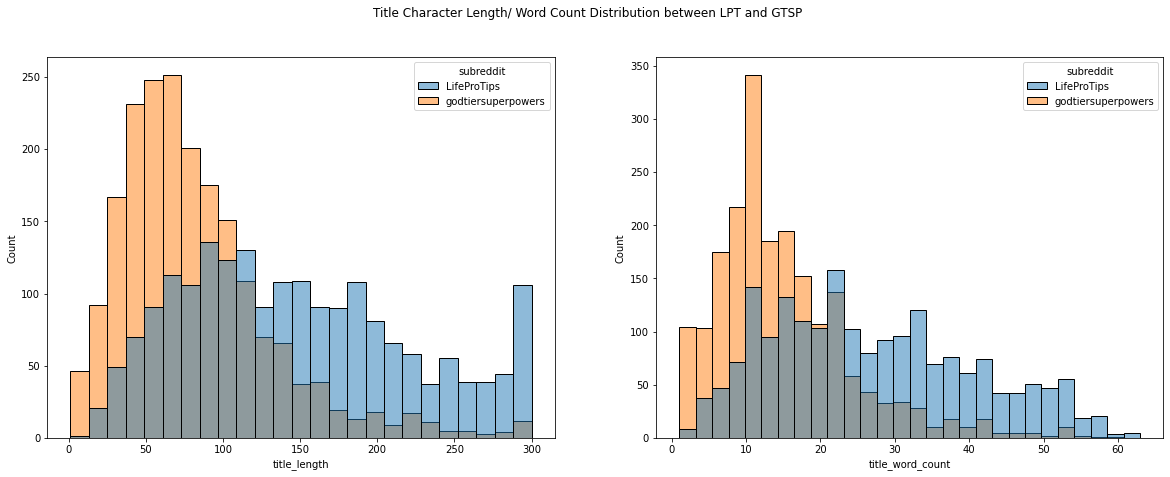

In [28]:
cols = ['title_length', 'title_word_count']

#1. Subplots of our distributions on chracter and word count
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

#axes.ravel() are the indexs used for subplotting
axes = axes.ravel()

#iterating to compare chracter and word count on both subreddits
for col, ax in zip(cols, axes):
    sns.histplot(x= df[col], data = df, hue = 'subreddit', ax=ax)

fig.suptitle('Title Character Length/ Word Count Distribution between LPT and GTSP')

Text(0.5, 0.98, 'Title Character Length/  Boxplot between LPT and GTSP')

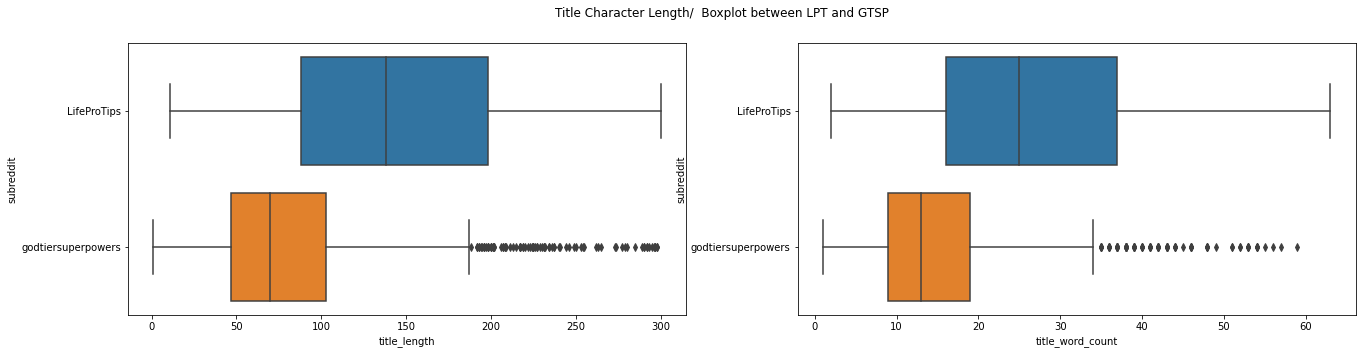

In [29]:
#2. Subplots of our boxplots on chracter and word count
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

for col, ax in zip(cols, axes):
    sns.boxplot(data = df, x = df[col], y = df['subreddit'], ax=ax)
    
fig.suptitle('Title Character Length/  Boxplot between LPT and GTSP')

In [30]:
df[df['title_word_count'] < 16].shape

(1696, 9)

### Scores and num_comments
LifeProTips is a popular subreddit with 20,000,000+ members wheras godtiersuperpowers as only 360,000. This inevitably means that lifeprotips should have more traction in comments and a higher scoring average per post.

The distributions of the scores and number of comments highlight that many observations hold a value of 0. These probably belong to posts that were sorted by 'new' and even 'hot'. It's clear that LifeProTips is a more popular subreddit since most of LifeProTips (blue) observations are higher.

In [31]:
#Mean of post scores by subreddit
df.groupby('subreddit')['score'].mean()

subreddit
LifeProTips           26573.055556
godtiersuperpowers     6078.329665
Name: score, dtype: float64

In [32]:
#Mean of post comments by subreddit
df.groupby('subreddit')['num_comments'].mean()

subreddit
LifeProTips           831.522936
godtiersuperpowers    142.831416
Name: num_comments, dtype: float64

[Text(0.5, 1.0, 'Number of Comments distribution between LPT and GTSP')]

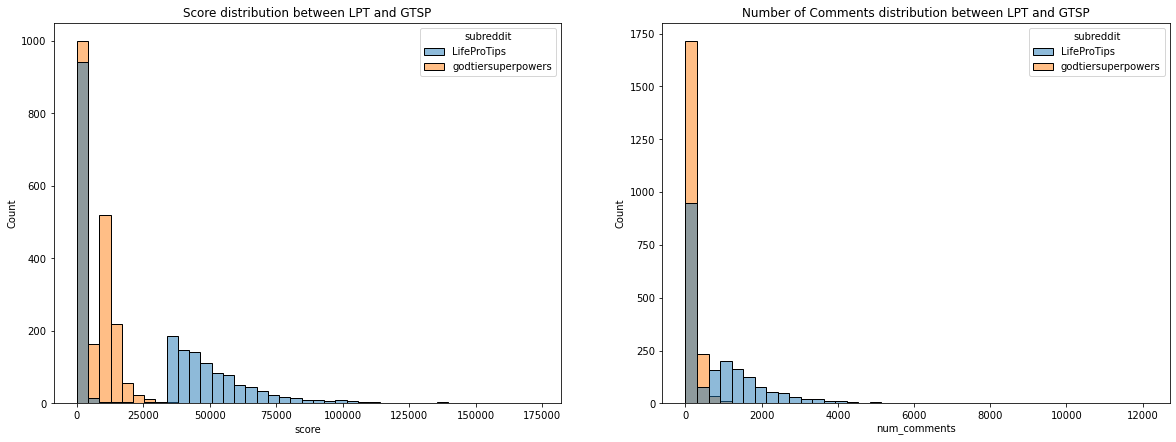

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

#plotting distribution of scores and number of comments by each subreddit
score = sns.histplot(data = df, x = df['score'], hue = 'subreddit', ax= axes[0])
num_comments = sns.histplot(data = df, x = df['num_comments'], hue = 'subreddit', bins = 40)

score.set(title= "Score distribution between LPT and GTSP")
num_comments.set(title= "Number of Comments distribution between LPT and GTSP")

### Summary Statistics
An overlook on the data:
- The mean of score and num_comments would be affected by the large amonut of 0 observations
- Bit more than half of the observations had self_text
- The most popular post had 173,391 upvotes
- A few posts somehow only have 1 word

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
self_text,3961.0,0.513254,0.499887,0.0,0.0,1.0,1.0,1.0
score,3961.0,16229.971219,23108.060850,0.0,17.0,7076.0,33995.0,173391.0
num_comments,3961.0,483.960616,842.123510,0.0,6.0,95.0,611.0,12106.0
title_length,3961.0,113.722040,71.321188,1.0,60.0,96.0,155.0,300.0
title_word_count,3961.0,20.878061,13.080733,1.0,11.0,17.0,29.0,63.0


**Posts with 1 word**<br>
Some of these posts seem to have their self_text as their description. 1 interesting instance has emojis between each word instead of spaces, which explains why title_word_count which count's spaces didn't pick this up. This won't affect our data with 19 instances of 1 word titles.

In [35]:
df[df['title_word_count'] == 1].shape

(19, 9)

In [36]:
df[df['title_word_count'] == 1].head(5)

,id,url,title,self_text,score,num_comments,subreddit,title_length,title_word_count
12,dt5u4w,https://www.reddit.com/r/godtiersuperpowers/co...,Putting👏claps👏between👏every👏word👏you👏type👏in👏a...,0,14281,478,godtiersuperpowers,104,1
63,ukde9n,https://www.reddit.com/r/godtiersuperpowers/co...,.,1,542,37,godtiersuperpowers,1,1
170,tuwen4,https://www.reddit.com/r/godtiersuperpowers/co...,Plant,1,8,2,godtiersuperpowers,5,1
206,te86aq,https://www.reddit.com/r/godtiersuperpowers/co...,Icon.,1,2,0,godtiersuperpowers,5,1
666,ctwvck,https://i.redd.it/t6vuq0i93zh31.png,This,0,19926,241,godtiersuperpowers,4,1


### Multi-collinearity
Logistic Regression assumes that there is no multi-collinearity between features. We can observe that score and num_comments do have some collinearity but with a Variance Indication Factor test they hold no significance with values under 10. An explanation for this is because more popular posts (with higher scores) would gain more traction therefore increasing the number of comments. 

In [37]:
#title_length will no longer be taken to account as it represents the same thing as title_word_count = multi-collinearity
features_df = df[['self_text', 'score', 'num_comments', 'title_word_count']]

<Figure size 360x360 with 0 Axes>

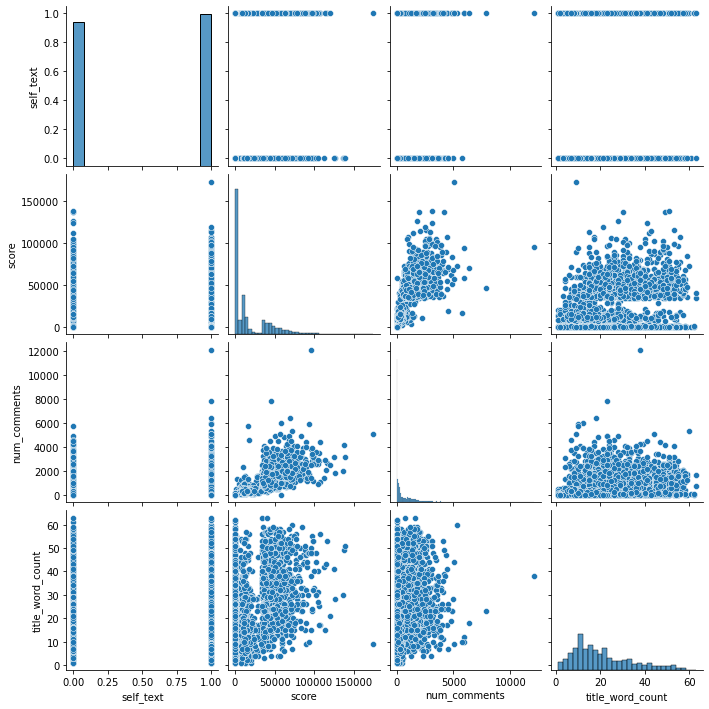

In [38]:
#Plotting the features against each other to observe wether there is any linear relationship
plt.figure(figsize = (5,5))
sns.pairplot(data = features_df)

### Variance Inflation Factor (VIF)
VIF measures the ratio between the variance for a given regression coefficient with only that variable in the model versus the variance for a given regression coefficient with all variables in the model. A good indication of multicollinearity is if there is a VIF > 10 for that feature.

In [39]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_df.columns
vif_data["VIF"] = [variance_inflation_factor(features_df.values, i) for i in range(len(features_df.columns))]

vif_data

,feature,VIF
0,self_text,1.479507
1,score,5.211588
2,num_comments,4.212990
3,title_word_count,2.276292


**Saving cleaned and concatenated data to new csv file**

In [40]:
#saving as sub_data.csv

# df.to_csv('../data/sub_data.csv', index = False)

In [41]:
df.shape

(3961, 9)

# Pre-processing for NLP
Our titles need to be pre-processed so that we have information that is more interpretable for our models. This involves:
1. Separation of our words as individual strings and removal of special characters with RegularExpression Tokenizer
2. Finding roots of words with Lemmatizer
3. Stop word removal

A train-validation-test split will then be created from our data to prepare for modelling.

**Making all titles as lowercase**

In [42]:
#making all title strings into lower case
df['title'] = df['title'].map(lambda x: x.lower())

In [43]:
#########before further pre-processing, making a copy of df for later use
df_copy = df.copy()

_______
## **WORD REMOVAL SECTION
### Removing unnecessary words
The removal of words have been decided from insight into the most popular words that don't help the model differentiate between subreddit. Further explanation into this is found when we look into 'the relationship of our words in 'Investigating relationships with our words on train set'.

In addition, many LPT post titles starts with 'LPT:' because it is a culture for this subreddit. This makes it too easy for our model to learn so I decided to remove it.

In [44]:
#using mapping to remove any word from all titles in df
def remove_it(word):
    return df['title'].map(lambda x: x.replace(f'{word}', ''))

**'LPT' removal from titles**

In [45]:
df[df['title'].str.contains('lpt')].head(1)

,id,url,title,self_text,score,num_comments,subreddit,title_length,title_word_count
0,uh5vtk,https://www.reddit.com/r/LifeProTips/comments/...,lpt: on iphone if you move your cursor with tw...,1,12,5,LifeProTips,71,14


In [46]:
#1961 posts have 'LPT:' in it
df[df['title'].str.contains('lpt')].shape

(1961, 9)

In [47]:
#re-defining titles without the word 'LPT'
df['title'] = remove_it('lpt')
df.head(1)

,id,url,title,self_text,score,num_comments,subreddit,title_length,title_word_count
0,uh5vtk,https://www.reddit.com/r/LifeProTips/comments/...,: on iphone if you move your cursor with two f...,1,12,5,LifeProTips,71,14


**Confusing words to remove**<br> These words represent important words that may 'confuse' our model when differentiating non-fiction and fantasy.

In [48]:
remove = ['always', 'know']

for word in remove:
    df['title'] = remove_it(word)

__________

### Binarizing the target
LifeProTips = 1, godtiersuperpowers = 0
<br>This will follow **Binary Logistic Regression's assumption** on a binary target.

In [49]:
df['subreddit'] = df['subreddit'].map({'LifeProTips' : 1, 'godtiersuperpowers' : 0})

In [50]:
df['subreddit'].head()

0    1
1    0
2    1
3    0
4    0
Name: subreddit, dtype: int64

### 1. RegExp
I'll be using RegExp as a tokenizer to find patterns in words and digits which will in turn also remove punctuation, symbols etc.

**Tokenizing**<br> 'Tokenizing' will separate words as individual strings within a list. 

In [51]:
#making an example sentence to test my tokenizing
#the sentence holds a few challenges for tokenizing such as 'life-long' and 'don't'.
title = df['title'][0]
print(title)

: on iphone if you move your cursor with two fingers it selects text


In [52]:
#instantiating RegexpTokenizer
#the annotation expresses that words and digits should be used as an indicator to tokenize words
tokenizer = RegexpTokenizer('\w+|\d+')

In [53]:
df['title'] = df['title'].map(lambda x: tokenizer.tokenize(x))

In [54]:
# df['title'][1]

### 2. Finding roots with lemmatizer
Lemmatizer aims to derive the dictionary root of each word. i.e. 'running' = 'run' in root form.

In [55]:
lemmatizer = WordNetLemmatizer() 

In [56]:
#mapping the lemmatizer to the words within each title
df['title'] = df['title'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [57]:
# df['title'][1]

### 3. Stop word removal
We are now removing all of the most common words found in the stopwords.words('english') dictionary. This encompasses words such as 'the', 'and', 'a'. I like the sklearn stopwords list.

In [58]:
stopwords.words('english')[:5]

['i', 'me', 'my', 'myself', 'we']

In [59]:
df['title'] = df['title'].map(lambda x: [word for word in x if word not in stopwords.words('english')])

In [60]:
#stopwords.words has been able to remove all of the problems that we found with contractions i.e. 'don't' becoming 'don' and 't'
df['title'][1]

['immortal', 'want']

## Train Test Split

**Establishing our X matrix and y vector**<br>
Our X will hold the following features:
- title
- score
- self_text
- title_word_count
- num_comments

**NOTE:** Exclusion of title_length as title_word_count represents the same thing

Our y will be 'subreddit'

In [61]:
X = df[['title', 'score', 'self_text', 'title_word_count', 'num_comments']]
y = df['subreddit']

The train and test will have an 80%, 20% split of the original dataframe.

In [62]:
#Since test_size is set to 20%, X_rem and y_rem represent the remaining 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                  random_state = 9,
                                                    stratify = y)

In [63]:
#train size
X_train.shape, y_train.shape

((3168, 5), (3168,))

In [64]:
#remaining data sizes
X_test.shape, y_test.shape

((793, 5), (793,))

## Investigating relationships with our words on train set
After making the train test split, a pipeline will be used to apply Natural Language Processing (NLP) with TfidfVectorizer on the post title words. To look at the affect of NLP, a new dataframe with TfidVectorizer will be made to investigate what words will be influencing our model the most.

**What it does:** Transforms our titles strings into matrix data that places importance on words that are uncommon in titles compared to the other titles.

In [65]:
tvec = TfidfVectorizer(analyzer= lambda x: x)

#Creating a dataframe from the sparse matrix that is formed from our Tfidf Transformer
title_tvec = pd.DataFrame(tvec.fit_transform(X_train['title']).todense(), 
                          columns=tvec.get_feature_names_out())

In [66]:
title_tvec.head()

,0,00,000,000ft,010101,0142,08,1,10,100,...,ziplock,zipped,zombie,zone,zoom,zoophile,zoë,α,π,ゴゴゴゴ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.216956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Top 15 words**

These are pretty common words, I thought that action verbs that relate to superpowers would appear. 'get' is the most profound word by far with a score nearing 60. 

<AxesSubplot:title={'center':'Imporance of words between subreddits'}>

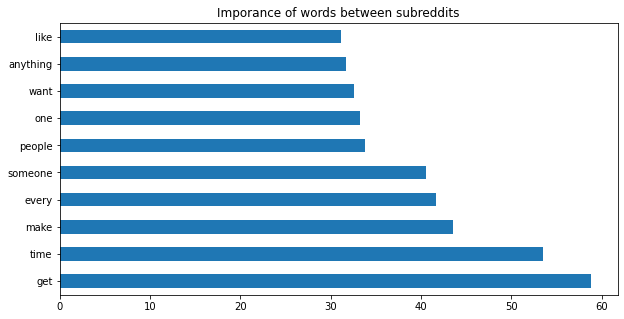

In [67]:
plt.figure(figsize = (10,5))
popular_words = title_tvec.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.title('Imporance of words between subreddits')
popular_words

**Superpower words**<br> Here's how TfidfVectorizer placed importance on words that would probably be found in godtiersuperpowers.

In [68]:
super_words = ['fly', 'invisible', 'fast', 'strength']

In [69]:
title_tvec[super_words].sum()

fly          4.877712
invisible    4.506965
fast         4.058460
strength     4.464937
dtype: float64

### **Balance of words between subreddits
To see the impact of these words, I look into the ratio of the appearance of these popular words in each subreddit. I aim to keep words that don't have a 50/50 split because it won't help the model differentiate between the 2 subreddits. These have been labelled as 'confusing' words.

In [70]:
words= []
for label in popular_words.get_yticklabels():
    words.append(label.get_text())

In [71]:
#function that finds the instances of a certain word in 'title' then will find its' prevalence in each subreddit
#as a %
def word_impact(words):
    for word in words:
        print(f'{word.upper()}')
        ###############df_copy was needed here as tokenizing has creates lists of words in
        # original df and won't let me use str.contains function
        print(df_copy[df_copy['title'].str.contains(f'{word}')]['subreddit'].value_counts(normalize = True))
    return 

We can see here that 'always' and 'know' have an equal balance between subreddits.

In [72]:
word_impact(words)

GET
LifeProTips           0.582878
godtiersuperpowers    0.417122
Name: subreddit, dtype: float64
TIME
godtiersuperpowers    0.613497
LifeProTips           0.386503
Name: subreddit, dtype: float64
MAKE
LifeProTips           0.630573
godtiersuperpowers    0.369427
Name: subreddit, dtype: float64
EVERY
godtiersuperpowers    0.762238
LifeProTips           0.237762
Name: subreddit, dtype: float64
SOMEONE
LifeProTips           0.587413
godtiersuperpowers    0.412587
Name: subreddit, dtype: float64
PEOPLE
LifeProTips           0.628019
godtiersuperpowers    0.371981
Name: subreddit, dtype: float64
ONE
LifeProTips           0.578883
godtiersuperpowers    0.421117
Name: subreddit, dtype: float64
WANT
LifeProTips           0.560669
godtiersuperpowers    0.439331
Name: subreddit, dtype: float64
ANYTHING
godtiersuperpowers    0.717105
LifeProTips           0.282895
Name: subreddit, dtype: float64
LIKE
LifeProTips           0.609959
godtiersuperpowers    0.390041
Name: subreddit, dtype: float64


**Removal of confusing words is in the 'WORD REMOVAL SECTION'**<br>
(this section is done in a previous part of this notebook)<br>
*'always'* and *'know'* were words that sat around a 50% ratio between the subreddits. 

**Superpower words**<br> 'Invisible' and 'Strength' are appear significantly more often in godtiersuperpowers

In [73]:
word_impact(super_words)

FLY
godtiersuperpowers    0.555556
LifeProTips           0.444444
Name: subreddit, dtype: float64
INVISIBLE
godtiersuperpowers    0.857143
LifeProTips           0.142857
Name: subreddit, dtype: float64
FAST
godtiersuperpowers    0.571429
LifeProTips           0.428571
Name: subreddit, dtype: float64
STRENGTH
godtiersuperpowers    0.875
LifeProTips           0.125
Name: subreddit, dtype: float64


# Modeling

**Transformers:**
- *TfidfVectorizer* 
    - Transforms our title's strings into matrix data that places importance on words that are uncommon in titles compared to the other titles.


- *StandardScaler* 
    - Scales our data to ensure that our features are comparable so that our model can understand the importance of features. 

**Models:**
- *RandomForestClassifier*
    - An ensemble model that will ensure that there is no multicollinearity problems with our dataset if we were to use an ordinary Decision Tree Classifier. At each split of       RandomForest, it will select a random subset of features to ensure that all words are exposing their relationship to our target. There are no assumptions on              distribution as it is non-parametric.


- *LogisticRegression*
    - Logistic Regression is great for binary classification problems and doesn't take assumptions for distributions either. Assumptions on outliers have been ignored and will be factored into our results.



### RandomForest Classifier and Logistic Regression Pipelines

In [74]:
#ColumnTransformer needs specified columns to affect
#all columns other than 'title' will need to be scaled
cols = list(X_train.columns)
cols.remove('title')
cols

['score', 'self_text', 'title_word_count', 'num_comments']

In [76]:
#Transformers for our pipelines
transformer = ColumnTransformer([
    #re-introducing the TfidVectorizer to the pipeline 
    ('tvec', TfidfVectorizer(analyzer= lambda x: x), 'title'),
    #cols used here
    ('s', StandardScaler(with_mean= False), cols)
])

#1. Randomforest classifier pipeline
pipe_forest = Pipeline([
    ('t', transformer),
    #class_weight favours 1 so that there are less misclassifications of 1
    ('rforest', RandomForestClassifier(class_weight = {0: 1, 1:1.4}))
])


#2. Logistic Regression pipeline
pipe_logreg = Pipeline([ 
    ('t', transformer),
    #penalty set to 'none' to avoid regularization
    ('logreg', LogisticRegression(penalty = 'none', class_weight = {0: 1, 1:1.4}))
    
])

#3. MultiNomial Bayes
pipe_mnb = Pipeline([ 
    ('t', transformer),
    #penalty set to 'none' to avoid regularization
    ('mnb', MultinomialNB())
    
])


## Optimizing hyperparameters
The hyperparameters within the transformers and models were adjusted to avoid overfitting and improve the balance between recall and specificity. Overfitting can be mitigated inside a forest classifier by reducing the depth (max_depth) of the tree. I aimed to improve recall and specificity by tweaking the max_features and min_df of the Tfidf Vectorizer parameters as it can increase individuality between the language of subreddits.

In [77]:
forest_params = {

    #RandomForest Classifier parameters
    'rforest__max_depth': [25],
    'rforest__n_estimators': [70],
    
    #Tfidf Vectorizor parameters
    't__tvec__max_df': [.97],
    't__tvec__max_features': [1000, 1200],
    't__tvec__min_df': [4],
    't__tvec__ngram_range': [(1,1), (1,2)]
      
}


tfidf_params = {
    #Tfidf Vectorizor parameters
    't__tvec__max_df': [.97],
    't__tvec__max_features': [2000],
    't__tvec__min_df': [3,4],
    't__tvec__ngram_range': [(1,1)]
}
    

## Gridsearch

In [78]:
#RandomForest gridseach over params outlined previously
forest_gs = GridSearchCV(pipe_forest,
                         forest_params,
                         cv= 5,
                         verbose = 1)

#LogisticRegression gridseach over params outlined previously
logreg_gs = GridSearchCV(pipe_logreg,
                         tfidf_params,
                         cv= 5,
                         verbose = 1)

#Naive Bayes
mnb_gs = GridSearchCV(pipe_mnb,
                         tfidf_params,
                         cv= 5,
                         verbose = 1)

In [79]:
forest_gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('t',
                                        ColumnTransformer(transformers=[('tvec',
                                                                         TfidfVectorizer(analyzer=<function <lambda> at 0x7fcd852858b0>),
                                                                         'title'),
                                                                        ('s',
                                                                         StandardScaler(with_mean=False),
                                                                         ['score',
                                                                          'self_text',
                                                                          'title_word_count',
                                                                          'num_comments'])])),
                                       ('rforest',
                                        

In [80]:
logreg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('t',
                                        ColumnTransformer(transformers=[('tvec',
                                                                         TfidfVectorizer(analyzer=<function <lambda> at 0x7fcd852858b0>),
                                                                         'title'),
                                                                        ('s',
                                                                         StandardScaler(with_mean=False),
                                                                         ['score',
                                                                          'self_text',
                                                                          'title_word_count',
                                                                          'num_comments'])])),
                                       ('logreg',
                                        L

In [81]:
mnb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('t',
                                        ColumnTransformer(transformers=[('tvec',
                                                                         TfidfVectorizer(analyzer=<function <lambda> at 0x7fcd852858b0>),
                                                                         'title'),
                                                                        ('s',
                                                                         StandardScaler(with_mean=False),
                                                                         ['score',
                                                                          'self_text',
                                                                          'title_word_count',
                                                                          'num_comments'])])),
                                       ('mnb', MultinomialNB())]),
             param_grid=

**Best scores:**

In [82]:
forest_gs.best_score_, logreg_gs.best_score_, mnb_gs.best_score_

(0.9267735135377577, 0.880055915200263, 0.8267067342433257)

**Best params for each model found by their gridsearch:**

In [83]:
forest_gs.best_params_

{'rforest__max_depth': 25,
 'rforest__n_estimators': 70,
 't__tvec__max_df': 0.97,
 't__tvec__max_features': 1000,
 't__tvec__min_df': 4,
 't__tvec__ngram_range': (1, 1)}

In [84]:
logreg_gs.best_params_

{'t__tvec__max_df': 0.97,
 't__tvec__max_features': 2000,
 't__tvec__min_df': 3,
 't__tvec__ngram_range': (1, 1)}

In [87]:
mnb_gs.best_params_

{'t__tvec__max_df': 0.97,
 't__tvec__max_features': 2000,
 't__tvec__min_df': 3,
 't__tvec__ngram_range': (1, 1)}

# Evaluation
Interpretation of the results from Logistic Regression need to take into account the fact that godtiersuperpowers has many outliers under 'title_word_count'. The only concern is that it may reduce the power of statistical tests.

## Baseline performance
The baseline accuracy is 50.47%. My models aim to outperform this.

In [88]:
y.value_counts(normalize = True)

0    0.504671
1    0.495329
Name: subreddit, dtype: float64

## Model performance
Optimizing for accuracy entails the focus on improving **recall**(type 1 errors) and **specificity** (type 2 errors) that describe our model's ability to correctly identify true positives and true negatives.

### Recall and Specificity
Our models have now been trained on data and is able to make certain predictions on the data we give it. When making these decisions on wether an observation is LifeProTips or godtiersuperpowers; how confident is it in this decision? We want our model to be able to differentiate 1 and 0 as certainly as possible, which can be represented by the tradeoff between Recall and Specificity. On top of accuracy being a suitable metric of success, our focus will also be in optimizing Recall (type 1 errors) and Specificity (type 2 errors) as they represent the ratio of our model correctly labelling the actual entries.


**RandomForest Classifier Interpretation:**
- A test accuracy of 0.91 means that 9% of the variance in the test set cannot be explained by our model.
- Recall of 0.91 states that 91% of our actual LifeProTips entries were classified correctly but 1 in 10 were misclassified as godtiersuperpowers
- Specificity of 0.92 states that 92% of our actual godtiersuperpower entries were classified correctly but 8% were misclassified as LifeProTips

#### **ForestTree Classifier overview**
This model was able to outperform Logistic Regression. In addition to a higher accuracy, it was able to achieve a much better balance of Recall and Specificity. Our train and test accuracy highlights that there is some evidence of bias as our model has been slightly overfitted.

The confusion matrix confirms that specificity performs better than recall as it's ability to classify true negatives (top left) triumphs its ability to classify true positives (bottom right).

In [91]:
#get_metrics will will give the metrics that are in question- accuracy of train and test samples, recall, specificity
func.get_metrics(forest_gs, X_test, y_test)

Train accuracy: 0.9267735135377577
Test accuracy: 0.9029003783102144
Recall: 0.8931297709923665
Specificity: 0.9125


In [ ]:
#plotting the confusion matrix for both models
plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(forest_gs, X_test, y_test,
                     cmap = 'BuGn',
                     display_labels = ['godtiersuperpowers', 'LifeProTips'])
plt.title('ForestTree Classifier Confusion Matrix')

#### **Logistic Regression overview** 
There was less flexibility with this model since I could not tune it's hyperparams since many of them became redundant after setting penaly = 'none'. Logistic Regression notably has a high Recall, suprisingly better than RandomForest by 1%. Specificity is quite a lot worse with 84%.

The confusion matrix highlights how negative observations (godtiersuperpowers) were more troublesome to classify for Logistic Regression. 



In [92]:
func.get_metrics(logreg_gs, X_test, y_test)

Train accuracy: 0.880055915200263
Test accuracy: 0.8751576292559899
Recall: 0.910941475826972
Specificity: 0.84


Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

<Figure size 360x360 with 0 Axes>

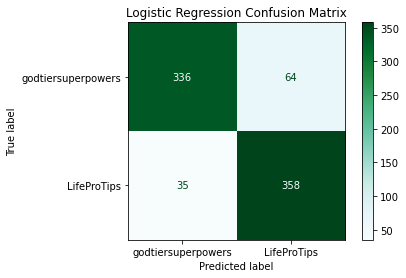

In [94]:
plt.figure(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(logreg_gs, X_test, y_test,
                     cmap = 'BuGn',
                     display_labels = ['godtiersuperpowers', 'LifeProTips'])
plt.title('Logistic Regression Confusion Matrix')

#### **MultiNomial Naive Bayes overview** 
Even worse performance for everything but a great balance between the train test accuracy, as well as recall vs specificity.

The confusion matrix reveals how there was an overall struggle in identifying the right subreddits compared to the other model.

In [93]:
func.get_metrics(mnb_gs, X_test, y_test)

Train accuracy: 0.8267067342433257
Test accuracy: 0.8297604035308953
Recall: 0.821882951653944
Specificity: 0.8375


Text(0.5, 1.0, 'MNB Regression Confusion Matrix')

<Figure size 360x360 with 0 Axes>

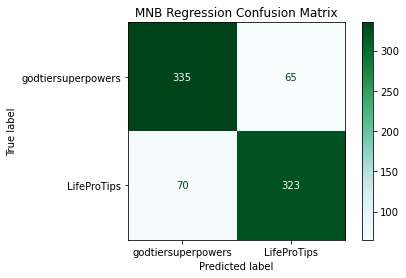

In [95]:
plt.figure(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(mnb_gs, X_test, y_test,
                     cmap = 'BuGn',
                     display_labels = ['godtiersuperpowers', 'LifeProTips'])
plt.title('MNB Regression Confusion Matrix')

### Distribution of our predicted probablities  
The model's predicted probabilities quantifies the confidence of our model towards its' decisions when classifying this binary target with a threshold set at 0.5. Recall and specificity represents the distribution of predicted probabliities towards 1 and 0 respectively. Misclassifications happen when the predicted probability falls into the wrong side of this threshold.

The distributions of these predicted probabilities need to be as seperate as possible so that there is less confusion around the 0.5 threshold. 

#### ROC curve

Shows the trade-off of our model's performance in context to Recall and Specificity as the threshold of our predicted probabilities change.

#### Area Under Curve (AUC) score
AUC is an indication of the performance of the model across all possible classification thresholds, representing how separated our positive and negative populations are from each other. We aim to have a higher AUC as it indicates less overlapping between the distributions.

#### **RandomForest Classifier Performance and Distributions**

With an AUC of 0.97, we can safely say that this model classifies subreddits correctly since it's overall performance is high in context to the changing thresholds on the predicted probabilities. 

This can be visualised with the distribution of the actual values and how they were placed in terms of predicted probabilities. There isn't too much evidence of overlap.

AUC: 0.9730534351145037


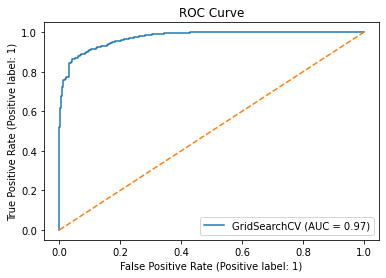

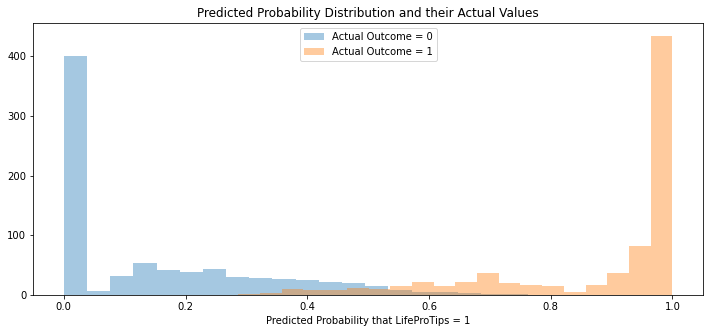

In [96]:
func.recall_specificity(forest_gs, X_test, y_test)

#### **Logistic Regression Performance and Distributions**
With an AUC of 0.88, this model has more trouble correctly classifying subreddits. The ROC curve is has flat sides, making it look like a triangle. This is because the ROC curve evaluates performance based on changing thresholds but evidence from the distributed predicted probabilities show that the changing threshold wouldn't have impact on the performance.

Interstingly, the predicted probabilities didn't show as much uncertainty but still has a problem with misclassifying observations.

In [97]:
pd.DataFrame({'true_values': y_test,
                            'pred_probs': logreg_gs.predict_proba(X_test)[:,1]}).head(10)

,true_values,pred_probs
741,1,1.0
3422,1,1.0
3443,0,0.0
232,1,1.0
3353,1,1.0
3304,1,1.0
3287,0,1.0
3914,1,1.0
2096,0,1.0
2523,1,1.0


AUC: 0.8790458015267175


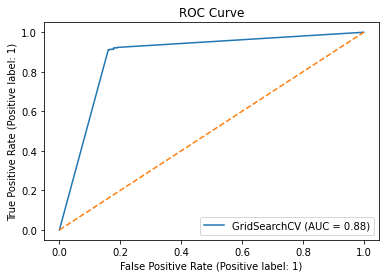

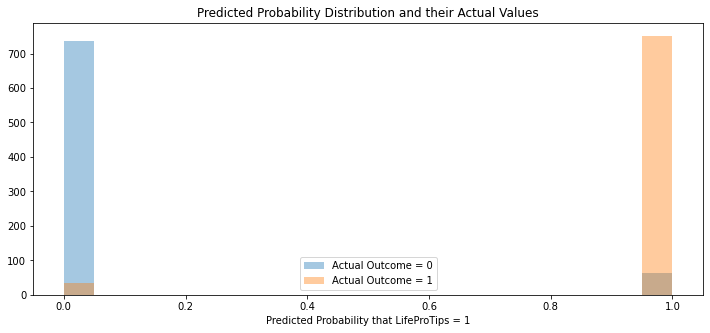

In [98]:
func.recall_specificity(logreg_gs, X_test, y_test)

#### **Multi-Nomial Naive Bayes Performance and Distributions**
The ROC curve visibly indicates that this model did not perform well. This 

AUC: 0.9249491094147582


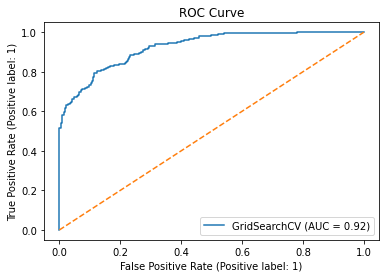

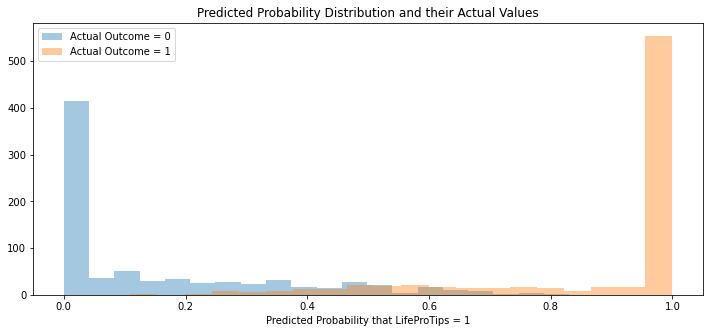

In [99]:
func.recall_specificity(mnb_gs, X_test, y_test)

### Conclusion and Recommendations

**Conclusion:** <br>
ForestTree Classifier is the model of choice as it is able to distinguish between non-fiction and fantasy quite confidently with reference to the AUC score of 0.97! LifeProTips and godtiersuperpowers share similar language but that wasn't changing model's ability to bypass that impressively. With an optimistic view of this performance, we can further this project to analyse data for facebook and perhaps discern fake news from real news.

**Recommendations:** <br>
Words that were obviously more prominant in godtiersuperpowers such as 'invisible' didn't hold as much weight as I'd like them to have. If I were able to weight words with a higher disparity of balance between subreddits, I feel that the model could perform even better. 